In [1]:
import os
import pandas as pd
import os.path as osp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load files

In [2]:
os.getcwd()

'D:\\Project- Electro\\social_behavior_electro\\data_organization\\python'

In [3]:
folder_path = osp.join('..','..','analysis')
path_to_aversive = osp.join(folder_path,
                            'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_aversive.xlsx')
path_to_affiliative = osp.join(folder_path,
                               'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_affiliative.xlsx')
path_to_common_areas = osp.join(folder_path, 'common_area_pairs_w5_sessions.xlsx')



In [4]:
df_aff = pd.read_excel(path_to_affiliative,None)
df_avv = pd.read_excel(path_to_aversive,None)

df_files_avv = pd.read_excel(path_to_aversive,'Uploaded files', header=None)
df_files_aff = pd.read_excel(path_to_affiliative,'Uploaded files', header=None)

df_areas = pd.read_excel(path_to_common_areas)


## Get info

### Number of sessions in each state

In [5]:
def get_number_of_sessions(df):
    max_len = 0
    for df_t in df.values():
        # find the max length
        max_len = max(max_len, len(df_t))
    return max_len

In [6]:
n_sssions_aff = get_number_of_sessions(df=df_aff)
n_sssions_avv = get_number_of_sessions(df=df_avv)

In [8]:
# I had to hard code this part since the names on the tables are different
important_pairs_in_data = [
    ('Area 111 MeA', 'Area 13 CeA'),
    ('Area 111 MeA', 'Area 112 BMA'),
    ('Area 111 MeA', 'Area 14 AA/ACO/VEN'),
    ('Area 111 MeA', 'Area 16 EA'),
    ('Area 111 MeA', 'Area 12 STIA'),
    ('Area 2 MePV', 'Area 112 BMA'),
    ('Area 13 CeA', 'Area 12 STIA'),
    ('Area 112 BMA', 'Area 14 AA/ACO/VEN')
]


## Get important pairs directly from the tables

In [9]:
# Each pair must appear in at least 5 session in each state
'''
- loop over all possible pairs and count the number of session for each pair
- keep only the pairs that were mesured only match conditions
'''
def get_area_names(df):
    all_areas = [area.replace('During','').replace('Before','').replace('First','').replace('Second','') for area in list(df.keys())]
    all_areas = set(all_areas)
    all_areas = all_areas - set(['NormMinus','Uploaded files'])
    return all_areas
areas_aff = get_area_names(df_aff)
areas_avv = get_area_names(df_avv)

common_areas = areas_aff.intersection(areas_avv)

def search_tuple_in_array_no_order(t, t_array):
    t_array = list(t_array)
    for t2 in t_array:
        if set(t) == set(t2):
            return True
        return False
    

def get_n_session_for_each_pair(df):
    MIN_N_SESSION = 5
    ret = dict()
    for area_sheet, data in df.items():
        # Only look at "First" (frequency range)
        if 'Norm' in area_sheet or 'Uploaded files' in area_sheet or 'Second' in area_sheet:
            continue
        area_name = area_sheet.replace('During','').replace('Before','').replace('First','')
        n_sessions = data.count()
        valid_session_ind = n_sessions>=MIN_N_SESSION
        valid_area_pairs = list(n_sessions[valid_session_ind].index)
        
        for area2 in valid_area_pairs:
            if search_tuple_in_array_no_order((area_name, area2), ret.keys()):
                continue
            ret[tuple(sorted([area_name, area2]))] = n_sessions[area2]
         
    return ret



In [10]:
valid_avv = get_n_session_for_each_pair(df = df_avv)
valid_aff = get_n_session_for_each_pair(df = df_aff)


In [11]:
# combine two dicts, keep only common keys
# folter non common pairs
common_pairs = set(valid_avv.keys()).intersection(set(valid_aff.keys())) # this is ok since the tuples are sorted
# convert to dataframe
dict_sum = {}
dict_sum['affiliative'] = {p:valid_aff[p] for p in common_pairs}
dict_sum['aversive'] = {p:valid_avv[p] for p in common_pairs}

In [13]:
df_counts = pd.DataFrame.from_dict(dict_sum)
df_counts

,,affiliative,aversive
AA,BMA,5,6
CeA,MeD,6,12
MeD,STIA,5,11
BMA,MeD,15,7
EA,MeD,8,11
BMA,MePV,9,6
CeA,STIA,5,10
AA,MeD,10,14


## Extract means and std

In [15]:
def fix_file_paths(df_files):
    
    df_files = df_files.rename(columns={df_files.columns[0]:'timestamps', df_files.columns[0]:'lfp', })
    
    return df_files
    
def extreact_vals(df, pair, df_file_paths, range_of_freq='First', call_num=0):

    all_sheet_names = df.keys()
    sheet_name = [n for n in all_sheet_names if range_of_freq in n and pair[0] in n][0]
    vals = df[sheet_name][pair[1]].values
    if len(vals)>0:
        non_nan_vals = ~np.isnan(vals)
        vals = vals[np.where(non_nan_vals)]
        try:
            filenames = df_file_paths.iloc[np.where(non_nan_vals)]
        except:
            print('Printing data of df files')
            print(np.where(non_nan_vals))
            print(df_file_paths['lfp'])
            print(range_of_freq)
            return 


    else:
        vals = []
        filenames = []

    if len(vals)==0 and call_num==0:
        vals, filenames = extreact_vals(df, (pair[1],pair[0]),df_file_paths, range_of_freq,call_num=1)
        
    return vals, filenames


In [16]:
df_file_paths_aff = fix_file_paths(df_files_aff)
df_file_paths_avv = fix_file_paths(df_files_avv)

# vals_aff, filenames_aff = extreact_vals(df=df_avv, df_file_paths=df_file_paths_aff, pair=('AA', 'BMA'), range_of_freq='First', call_num=0)

In [17]:

# columns names: pair, sosicability, coherence, filenaem 
# first range - 4-12 Hz
# second range - 30-80 Hz
sociability = {'affiliative':df_file_paths_aff,'aversive':df_file_paths_avv}
df_sociability = {'affiliative':df_aff,'aversive':df_avv}
# sociability = {'affiliative':df_file_paths_aff}
# df_sociability = {'affiliative':df_aff}


frequency_bands = {'First':'4-12','Second':'30-80'}

df_sum_list = []
for pair in common_pairs:
    for social in sociability.keys():
        for freq in frequency_bands.keys():

#             try:
            vals, filenames = extreact_vals(
                df=df_sociability[social],
                pair=pair,
                df_file_paths=sociability[social],
                range_of_freq=freq,
                call_num=0)
    
                
            temp_dict ={'area1': pair[0],
                        'area2': pair[1],
                        'sociability': social, 
                        'frequency_band': frequency_bands[freq],
                        'coherence': vals,
                       'files': filenames.lfp.values}
            temp_df = pd.DataFrame.from_dict(temp_dict)
#             temp_df.columns = temp_df.columns[::-1]
            df_sum_list.append(temp_df)
df_sum = pd.concat(df_sum_list)

df_sum_list2= []
for pair in common_pairs:
    for social in sociability:
        for freq in frequency_bands.keys():
            
            vals, filenames = extreact_vals(
                df=df_sociability[social],
                df_file_paths=sociability[social],
                pair=pair,
                range_of_freq=freq,
                call_num=0)
            
            
            temp_dict ={pair: {'sociability': social, 
                               'frequency_band': frequency_bands[freq],
                               'coherence': vals,
                              'files':filenames.lfp.values}}
            temp_df = pd.DataFrame.from_dict(temp_dict).transpose()
#             temp_df.columns = temp_df.columns[::-1]
            df_sum_list2.append(temp_df)
df_sum2 = pd.concat(df_sum_list2)
df_sum2 = df_sum2[df_sum2.columns[::-1]]
df_sum2['mean'] = df_sum2['coherence'].apply(lambda x: np.mean(x))
df_sum2['std'] = df_sum2['coherence'].apply(lambda x: np.std(x))
df_sum2['median'] = df_sum2['coherence'].apply(lambda x: np.median(x))
df_sum2 = df_sum2.reset_index()
df_sum2 = df_sum2.rename(columns={'level_0':'area1', 'level_1': 'area2'})
df_sum2.columns

Index(['area1', 'area2', 'sociability', 'frequency_band', 'files', 'coherence',
       'mean', 'std', 'median'],
      dtype='object')

In [18]:
df_sum2

,area1,area2,sociability,frequency_band,files,coherence,mean,std,median
0,AA,BMA,affiliative,4-12,[chamber_Rat16-probe18-day3-Behavior_and_Optog...,"[-0.08485020103548116, -0.08183394283217837, -...",-0.075196,0.048725,-0.081834
1,AA,BMA,affiliative,30-80,[chamber_Rat16-probe18-day3-Behavior_and_Optog...,"[-0.024921798695603126, -0.019307120745778478,...",-0.014084,0.007428,-0.013666
2,AA,BMA,aversive,4-12,[chamber_Rat16-probe18-day1-Behavior_and_Optog...,"[-0.033212836622513064, 0.025546737796704133, ...",-0.025982,0.063684,-0.004316
3,AA,BMA,aversive,30-80,[chamber_Rat16-probe18-day1-Behavior_and_Optog...,"[0.002800729134647517, 0.0020799764197723114, ...",-0.053587,0.106329,0.000607
4,CeA,MeD,affiliative,4-12,[chamber_Rat3-probe2-sniffing-day2-Behavior_an...,"[-0.2783367927282807, -0.1969289180747496, -0....",-0.124849,0.089331,-0.102381
5,CeA,MeD,affiliative,30-80,[chamber_Rat3-probe2-sniffing-day2-Behavior_an...,"[-0.14540752224689185, -0.22748645803561543, -...",-0.074453,0.086853,-0.044104
6,CeA,MeD,aversive,4-12,[chamber_Rat3-Probe2-sniffing-day1-Behavior_an...,"[0.09063561825729101, -0.11228825714121662, -0...",-0.033643,0.061981,-0.009842
7,CeA,MeD,aversive,30-80,[chamber_Rat3-Probe2-sniffing-day1-Behavior_an...,"[0.09663456862069986, -0.05443674361551626, -0...",0.003191,0.033525,-0.002598
8,MeD,STIA,affiliative,4-12,[chamber_Rat4-probe3-sniffing-day1-Behavior_an...,"[0.17707487052407306, -0.07009422296350468, 0....",0.013921,0.088013,0.005339
9,MeD,STIA,affiliative,30-80,[chamber_Rat4-probe3-sniffing-day1-Behavior_an...,"[0.07092586195916767, 0.030850766452594935, 0....",0.002875,0.061613,0.020622


In [19]:
df_sum.set_index(['files']).sort_index()

,area1,area2,sociability,frequency_band,coherence
files,,,,,
Chamber_Rat22-probe21-Day1-Behavior_and_Optogenetics_TimeStamps.mat,AA,BMA,affiliative,30-80,-0.013666
Chamber_Rat22-probe21-Day1-Behavior_and_Optogenetics_TimeStamps.mat,AA,BMA,affiliative,4-12,-0.003328
Chamber_Rat23-probe22-Day1-Behavior_and_Optogenetics_TimeStamps.mat,AA,MeD,aversive,30-80,-0.017622
Chamber_Rat23-probe22-Day1-Behavior_and_Optogenetics_TimeStamps.mat,CeA,MeD,aversive,30-80,0.030377
Chamber_Rat23-probe22-Day1-Behavior_and_Optogenetics_TimeStamps.mat,CeA,MeD,aversive,4-12,0.001158
...,...,...,...,...,...
chamber_rat14-probe14-day 1-Behavior_and_Optogenetics_TimeStamps.mat,BMA,MeD,affiliative,30-80,-0.000660
chamber_rat14-probe14-day 1-Behavior_and_Optogenetics_TimeStamps.mat,BMA,MePV,affiliative,4-12,0.075614
chamber_rat14-probe14-day 1-Behavior_and_Optogenetics_TimeStamps.mat,BMA,MeD,affiliative,4-12,0.049538


In [20]:
area_pairs = df_sum[['area1','area2']].values
area_pairs = [(a,b) for a,b in area_pairs]
df_sum['area_pairs'] = area_pairs

In [21]:
area_pairs = df_sum2[['area1','area2']].values
area_pairs = [(a,b) for a,b in area_pairs]
df_sum2['area_pairs'] = area_pairs


In [22]:
df_sum2.set_index(['area1', 'area2', 'sociability', 'frequency_band']).unstack(['sociability', 'frequency_band'])['median']

sociability    affiliative            aversive          
frequency_band        4-12     30-80      4-12     30-80
area1 area2                                             
AA    BMA        -0.081834 -0.013666 -0.004316  0.000607
      MeD        -0.107049 -0.026070 -0.002784 -0.002191
BMA   MeD         0.008472 -0.000660 -0.005398 -0.000148
      MePV        0.004017  0.000994 -0.029782 -0.026578
CeA   MeD        -0.102381 -0.044104 -0.009842 -0.002598
      STIA       -0.073944 -0.029949 -0.035234 -0.003435
EA    MeD        -0.101067 -0.010300 -0.108967 -0.035524
MeD   STIA        0.005339  0.020622  0.026095  0.004391

,,affiliative,aversive
AA,BMA,5,6
CeA,MeD,6,12
MeD,STIA,5,11
BMA,MeD,15,7
EA,MeD,8,11
BMA,MePV,9,6
CeA,STIA,5,10
AA,MeD,10,14


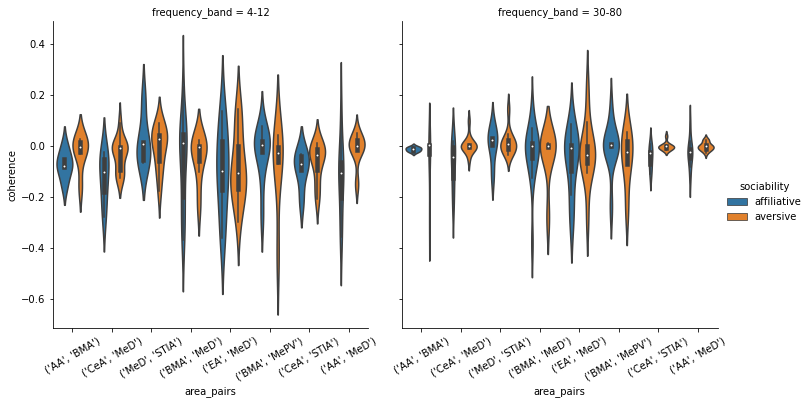

In [23]:
g = sns.catplot(data=df_sum, x='area_pairs', y='coherence', hue='sociability', kind='violin', col='frequency_band')
g.set_xticklabels(rotation=30)
df_counts

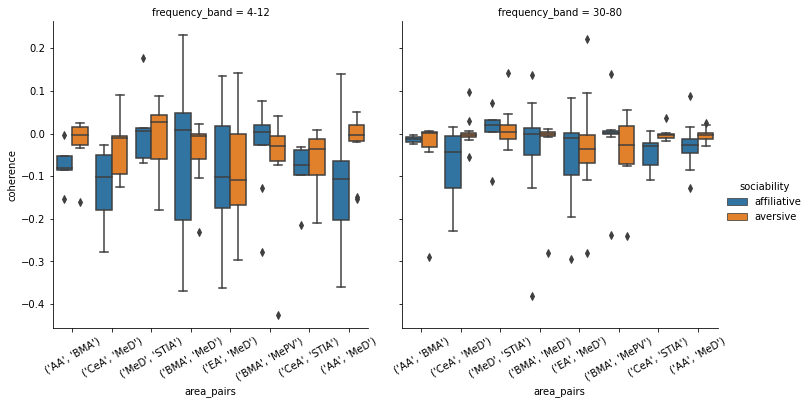

In [24]:
g = sns.catplot(data=df_sum, x='area_pairs', y='coherence', hue='sociability', kind='box', col='frequency_band')
g.set_xticklabels(rotation=30)


## Statistical Analysis

In [22]:
df_sum.to_excel(osp.join(folder_path, 'coherence_summary_table.xlsx'))

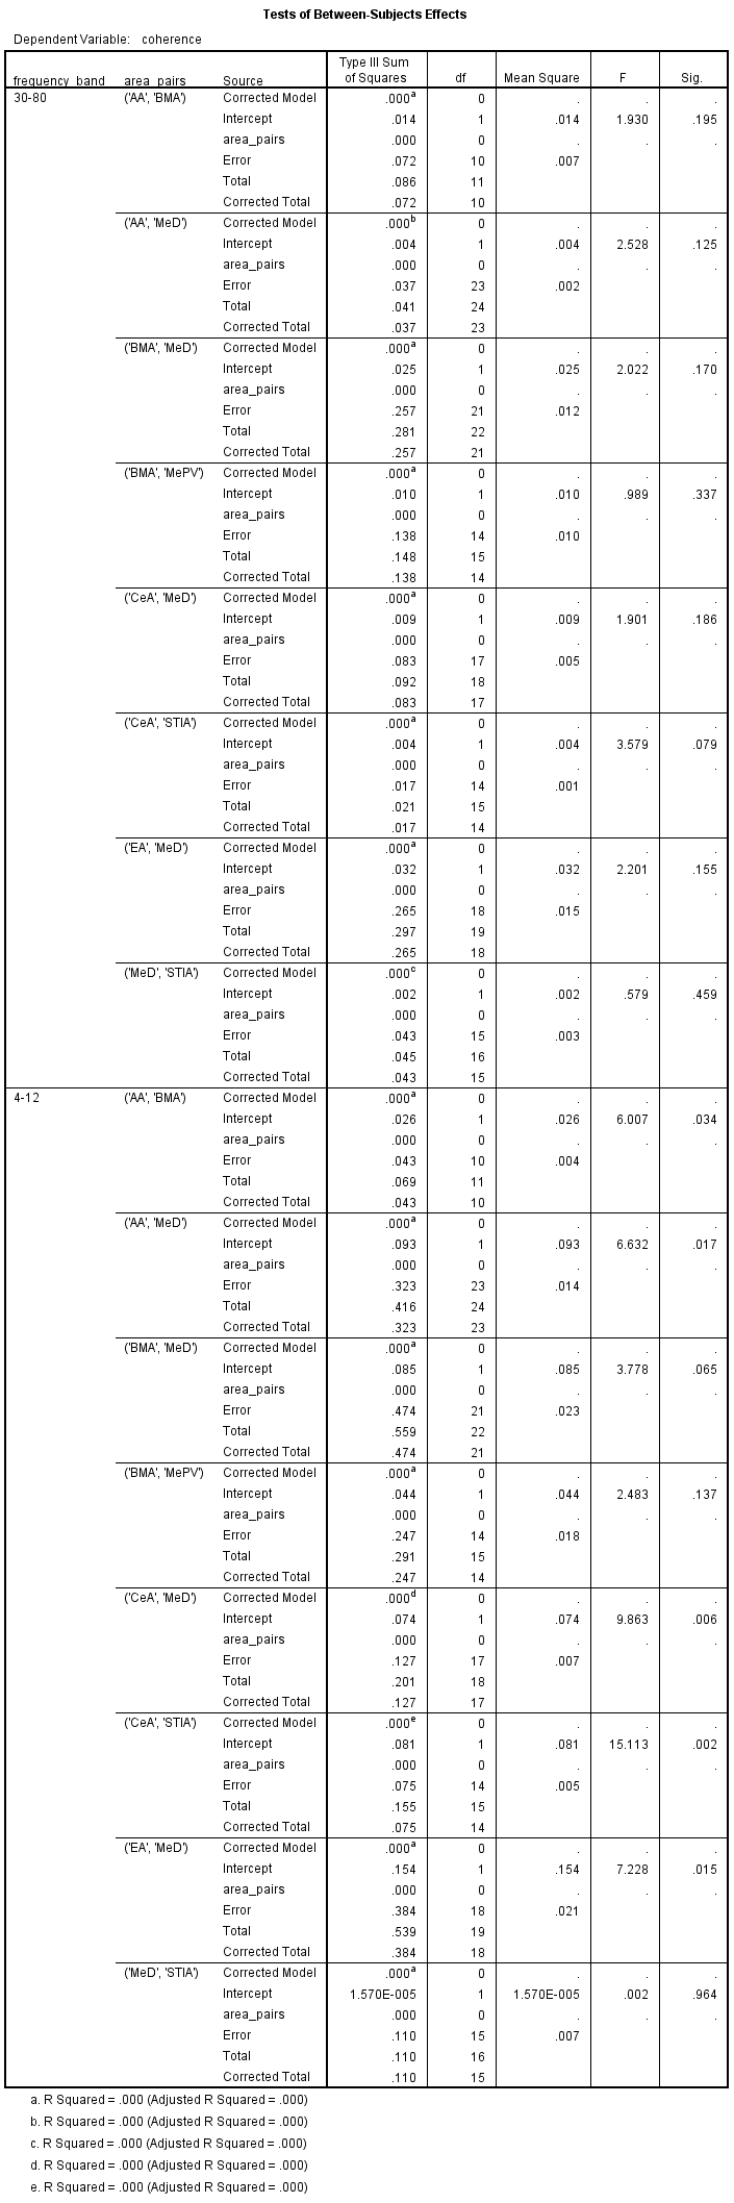

### Mann Whitney U test

In [110]:
from scipy.stats import mannwhitneyu
def mannwhitneyu_test(df, pairs, freq_band):
    ret = {}
    for pair in pairs:
        sub_df = df.loc[(df['area_pairs'] == pair) & (df['frequency_band']==freq_band)]
        vals_1 = sub_df.loc[df['sociability']== 'affiliative' ]['coherence'].values
        vals_2 = sub_df.loc[df['sociability']== 'aversive' ]['coherence'].values
        
#         print(vals_1)
#         print(vals_2)
        
        res = mannwhitneyu(vals_1[0], vals_2[0])
        ret[pair] = {'stat': res.statistic, 'pval': res.pvalue}
    return ret


In [111]:
ret_all = []

pairs = df_sum2['area_pairs'].unique()
ret = mannwhitneyu_test(df_sum2, pairs, '4-12')
ret = pd.DataFrame.from_dict(ret).transpose()
ret['freq'] = '4-12'
ret_all.append(ret)

pairs = df_sum2['area_pairs'].unique()
ret = mannwhitneyu_test(df_sum2, pairs, '30-80')
ret = pd.DataFrame.from_dict(ret).transpose()
ret['freq'] = '30-80'
ret_all.append(ret)
df_sig_pairs = pd.concat(ret_all)
# df_sig_pairs.to_clipboard()

df_sig_pairs

stat      pval   freq
AA  BMA    7.0  0.177489   4-12
CeA MeD   12.0  0.024456   4-12
MeD STIA  27.0  1.000000   4-12
BMA MeD   60.0  0.629796   4-12
EA  MeD   45.0  0.967849   4-12
BMA MePV  36.0  0.327672   4-12
CeA STIA  17.0  0.370962   4-12
AA  MeD   30.0  0.020729   4-12
    BMA   10.0  0.428571  30-80
CeA MeD   17.0  0.083064  30-80
MeD STIA  32.0  0.661172  30-80
BMA MeD   54.0  0.945211  30-80
EA  MeD   45.0  0.967849  30-80
BMA MePV  28.0  0.954645  30-80
CeA STIA   9.0  0.055278  30-80
AA  MeD   32.0  0.028108  30-80

In [112]:
df_sig_pairs = df_sig_pairs.loc[df_sig_pairs['pval']<=0.1]
df_sig_pairs.index.set_names(['area1', 'area2'], inplace=True)
df_sig_pairs = df_sig_pairs.reset_index().set_index(['freq', 'area1', 'area2'])
significant_names = list(df_sig_pairs.index)
# df_sig_pairs.to_clipboard()

In [113]:
significant_areas = [(a,b) for c,a,b in significant_names]
significant_freqs = [c for c,a,b in significant_names]

In [115]:
significant_names

[('4-12', 'CeA', 'MeD'),
 ('4-12', 'AA', 'MeD'),
 ('30-80', 'CeA', 'MeD'),
 ('30-80', 'CeA', 'STIA'),
 ('30-80', 'AA', 'MeD')]

In [116]:
rat12 = df_sum.loc[df_sum['files'].str.contains('Rat12')]
rat12.drop('area_pairs', axis=1).set_index(['area1','area2','sociability','frequency_band', 'files']).unstack(['frequency_band','area1','area2'])

coherence  \
frequency_band                                                      4-12   
area1                                                                CeA   
area2                                                                MeD   
sociability files                                                          
aversive    chamber_Rat12-probe16-day1_Behavior_and_Optogen...       NaN   
            chamber_Rat12-probe16-day2_Behavior_and_Optogen... -0.013246   

                                                                          \
frequency_band                                                     30-80   
area1                                                                CeA   
area2                                                                MeD   
sociability files                                                          
aversive    chamber_Rat12-probe16-day1_Behavior_and_Optogen...       NaN   
            chamber_Rat12-probe16-day2_Behavior_and_Optogen...  0.005105   

                                                                          \
frequency_band                                                      4-12   
area1                                                                MeD   
area2                                                               STIA   
sociability files                                                          
aversive    chamber_Rat12-probe16-day1_Behavior_and_Optogen...       NaN   
            chamber_Rat12-probe16-day2_Behavior_and_Optogen...  0.001144   

                                                                          \
frequency_band                                                     30-80   
area1                                                                MeD   
area2                                                               STIA   
sociability files                                                          
aversive    chamber_Rat12-probe16-day1_Behavior_and_Optogen...       NaN   
            chamber_Rat12-probe16-day2_Behavior_and_Optogen...  0.045031   

                                                                          \
frequency_band                                                      4-12   
area1                                                                CeA   
area2                                                               STIA   
sociability files                                                          
aversive    chamber_Rat12-probe16-day1_Behavior_and_Optogen...  0.008752   
            chamber_Rat12-probe16-day2_Behavior_and_Optogen... -0.011578   

                                                                          \
frequency_band                                                     30-80   
area1                                                                CeA   
area2                                                               STIA   
sociability files                                                          
aversive    chamber_Rat12-probe16-day1_Behavior_and_Optogen... -0.005318   
            chamber_Rat12-probe16-day2_Behavior_and_Optogen...  0.037575   

                                                                         \
frequency_band                                                     4-12   
area1                                                                AA   
area2                                                               MeD   
sociability files                                                         
aversive    chamber_Rat12-probe16-day1_Behavior_and_Optogen...      NaN   
            chamber_Rat12-probe16-day2_Behavior_and_Optogen... -0.00849   

                                                                          
frequency_band                                                     30-80  
area1                                                                 AA  
area2                                                                MeD  
sociability files                      

In [117]:
# filter the results and keep only the significant pair-freq combinations
all_sub_df = []
for f, area1, area2 in significant_names:
    sub_df = df_sum.loc[(df_sum['area_pairs'] == (area1, area2))&(df_sum['frequency_band']==f)]
    all_sub_df.append(sub_df)
df_sum_sig = pd.concat(all_sub_df)
df_sum_sig = df_sum_sig.drop(['area1','area2'], axis=1)
df_sum_sig = df_sum_sig.set_index(['files','area_pairs','sociability','frequency_band']).unstack(['frequency_band','area_pairs'])

## Draw a network graph

In [118]:
import networkx as nx
from scipy import stats



In [119]:
mean_co = df_sum2['mean'].values
z_means = stats.zscore(mean_co)
df_sum2['zscore_mean'] = z_means

In [120]:
def plot_network(area1_list, area2_list, vals, pos = None, th=None):
    G = nx.Graph()

    vals = np.round(vals,3)
    if th is None:
        th = np.mean(vals)
    
    # z_score_list_scale = (z_score_list-np.min(z_score_list))/(np.max(z_score_list)-np.min(z_score_list))
    # z_score_list_scale = np.round(z_score_list_scale,3)


    for a,b,c in zip(area1_list, area2_list, vals):
        G.add_edge(a, b, weight=c)
        

    
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > th]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= th]
    
    
    if pos is None:
#         pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility
        pos = nx.planar_layout(G)  # positions for all nodes - seed for reproducibility

    
    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)



    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)


    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    return pos, ax

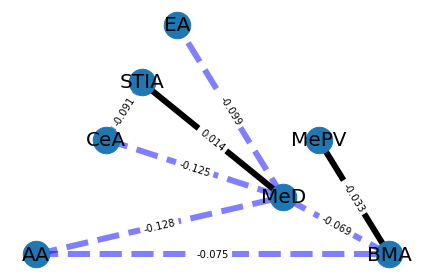

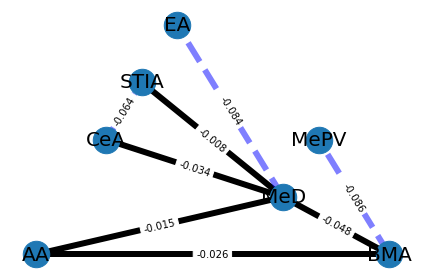

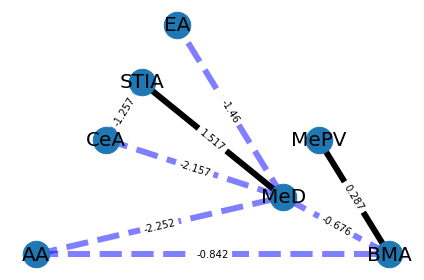

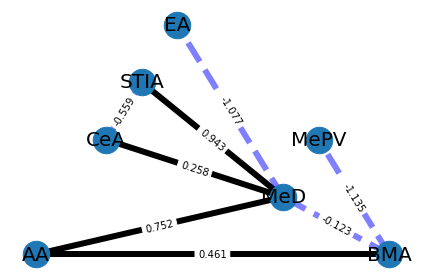

In [121]:
df_sum_aff_theta = df_sum2.loc[(df_sum2['sociability']=='affiliative')&(df_sum2['frequency_band']=='4-12')][['area1','area2','mean','zscore_mean']]
df_sum_avv_theta = df_sum2.loc[(df_sum2['sociability']=='aversive')&(df_sum2['frequency_band']=='4-12')][['area1','area2','mean','zscore_mean']]

area1_aff = df_sum_aff_theta['area1'].values
area2_aff = df_sum_aff_theta['area2'].values

area1_avv = df_sum_avv_theta['area1'].values
area2_avv = df_sum_avv_theta['area2'].values

means_aff = df_sum_aff_theta['mean'].values
means_avv = df_sum_avv_theta['mean'].values
mean_all = np.array([means_aff,means_avv]).mean()

zscore_aff = df_sum_aff_theta['zscore_mean'].values
zscore_avv = df_sum_avv_theta['zscore_mean'].values
mean_zscore_all = np.array([zscore_aff,zscore_avv]).mean()

pos, ax1 = plot_network(area1_aff, area2_aff, means_aff  ,pos=None , th=mean_all)
_, ax2 = plot_network(area1_avv, area2_avv, means_avv  ,pos , th=mean_all)

pos, ax1 = plot_network(area1_aff, area2_aff, zscore_aff  ,_ , th=0)
_, ax2 = plot_network(area1_avv, area2_avv, zscore_avv  ,pos , th=0)

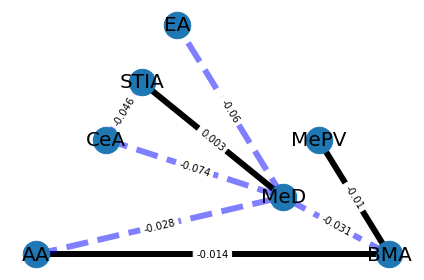

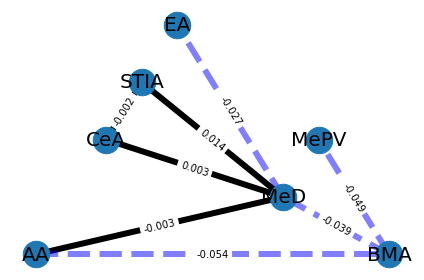

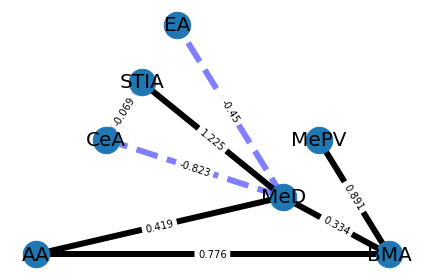

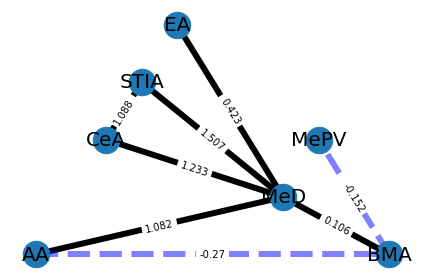

In [122]:
# Gamma

df_sum_aff_gamma = df_sum2.loc[(df_sum2['sociability']=='affiliative')&(df_sum2['frequency_band']=='30-80')][['area1','area2','mean','zscore_mean']]
df_sum_avv_gamma = df_sum2.loc[(df_sum2['sociability']=='aversive')&(df_sum2['frequency_band']=='30-80')][['area1','area2','mean','zscore_mean']]

area1_aff = df_sum_aff_gamma['area1'].values
area2_aff = df_sum_aff_gamma['area2'].values

area1_avv = df_sum_avv_gamma['area1'].values
area2_avv = df_sum_avv_gamma['area2'].values

means_aff = df_sum_aff_gamma['mean'].values
means_avv = df_sum_avv_gamma['mean'].values
mean_all = np.array([means_aff,means_avv]).mean()

zscore_aff = df_sum_aff_gamma['zscore_mean'].values
zscore_avv = df_sum_avv_gamma['zscore_mean'].values
mean_zscore_all = np.array([zscore_aff,zscore_avv]).mean()

pos, ax1 = plot_network(area1_aff, area2_aff, means_aff,  pos=None , th=mean_all)
_, ax2 = plot_network(area1_avv, area2_avv, means_avv  ,pos , th=mean_all)

pos, ax1 = plot_network(area1_aff, area2_aff, zscore_aff  ,_ , th=0)
_, ax2 = plot_network(area1_avv, area2_avv, zscore_avv  ,pos , th=0)




## Predictive model for rat group

In [123]:
significant_names

[('4-12', 'CeA', 'MeD'),
 ('4-12', 'AA', 'MeD'),
 ('30-80', 'CeA', 'MeD'),
 ('30-80', 'CeA', 'STIA'),
 ('30-80', 'AA', 'MeD')]

In [124]:
# # extreact the areas with high significans
# df_sum_sig = df_sum.loc[(df_sum['area_pairs'].isin(significant_areas))&(df_sum['frequency_band'].isin(significant_freqs))]
# # df_sum_sig = df_sum
# df_sum_sig = df_sum_sig[['sociability','files','area1', 'area2', 'frequency_band','coherence']].set_index(['sociability','files','area1', 'area2', 'frequency_band']).unstack(['area1', 'area2', 'frequency_band'])
# # df_sum_sig.reset_index()

In [125]:
df_sum_sig

coherence  \
frequency_band                                                       4-12   
area_pairs                                                     (CeA, MeD)   
files                                              sociability              
Chamber_Rat23-probe22-Day1-Behavior_and_Optogen... aversive      0.001158   
Chamber_Rat26-Probe25-Day1-Behavior_and_Optogen... affiliative        NaN   
Chamber_Rat26-Probe25-Day4-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat1-probe4-day1-Behavior_and_Optogenet... affiliative        NaN   
chamber_Rat1-probe4-day2-Behavior_and_Optogenet... affiliative        NaN   
chamber_Rat10-probe13-day1_Behavior_and_Optogen... aversive     -0.009950   
chamber_Rat10-probe13-day2_Behavior_and_Optogen... aversive     -0.009734   
chamber_Rat10-probe13-day3_Behavior_and_Optogen... aversive     -0.001878   
chamber_Rat10-probe13-day4_Behavior_and_Optogen... aversive     -0.125894   
chamber_Rat12-probe16-day1_Behavior_and_Optogen... aversive           NaN   
chamber_Rat12-probe16-day2_Behavior_and_Optogen... aversive     -0.013246   
chamber_Rat15-probe17-day1-Behavior_and_Optogen... affiliative  -0.131179   
chamber_Rat15-probe17-day2-Behavior_and_Optogen... aversive     -0.119880   
chamber_Rat15-probe17-day3-Behavior_and_Optogen... aversive     -0.090493   
chamber_Rat16-probe18-day1-Behavior_and_Optogen... aversive           NaN   
chamber_Rat16-probe18-day2-Behavior_and_Optogen... aversive           NaN   
chamber_Rat16-probe18-day3-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat17-probe14-Day1-Behavior_and_Optogen... aversive           NaN   
chamber_Rat17-probe14-day2-Behavior_and_Optogen... aversive           NaN   
chamber_Rat17-probe14-day5-Behavior_and_Optogen... aversive           NaN   
chamber_Rat19-Probe18-day1-Behavior_and_Optogen... aversive           NaN   
chamber_Rat19-Probe18-day3-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat19-probe18-Day2-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat19-probe18-day6-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat20-Probe19-day1-Behavior_and_Optogen... affiliative  -0.073583   
chamber_Rat21-probe20-day1-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat23-probe22-Day2-Behavior_and_Optogen... affiliative  -0.043003   
chamber_Rat3-Probe2-sniffing-Day3-Behavior_and_... affiliative  -0.196929   
chamber_Rat3-Probe2-sniffing-day1-Behavior_and_... aversive      0.090636   
chamber_Rat3-probe2-sniffing-day2-Behavior_and_... affiliative  -0.278337   
chamber_Rat3-probe2-sniffing-day4-Behavior_and_... aversive     -0.112288   
chamber_Rat4-probe3-sniffing-day1-Behavior_and_... affiliative  -0.026062   
chamber_Rat4-probe3-sniffing-day2-Behavior_and_... aversive     -0.006467   
chamber_Rat4-probe3-sniffing-day3-Behavior_and_... aversive     -0.005676   

                                                                          \
frequency_band                                                             
area_pairs                                                     (AA, MeD)   
files                                              sociability             
Chamber_Rat23-probe22-Day1-Behavior_and_Optogen... aversive    -0.018409   
Chamber_Rat26-Probe25-Day1-Behavior_and_Optogen... affiliative -0.089558   
Chamber_Rat26-Probe25-Day4-Behavior_and_Optogen... affiliative -0.332499   
chamber_Rat1-probe4-day1-Behavior_and_Optogenet... affiliative       NaN   
chamber_Rat1-probe4-day2-Behavior_and_Optogenet... affiliative       NaN   
chamber_Rat10-probe13-day1_Behavior_and_Optogen... aversive     0.007203   
chamber_Rat10-probe13-day2_Behavior_and_Optogen... aversive     0.028251   
chamber_Rat10-probe13-day3_Behavior_and_Optogen... aversive     0.049807   
chamber_Rat10-probe13-day4_Behavior_and_Optogen... aversive    -0.152558   
chamber_Rat12-probe16-day1_Behavior_and_Optogen... aversive          NaN   
chamber_Rat12-probe16-day2_Behavior_and_Optogen... aversive    -0.008490 

In [126]:
len(df_sum_sig)

34

In [127]:
# data = df_sum_sig.reset_index().copy()
# data.columns = data.columns.get_level_values(0) 
# filenames = data['files'].values
# data = data.drop('files', axis=1)

# n_col = len(data.columns)
# data = data.set_axis(range(n_col), axis=1)
# data.rename(columns={0: 'dependent_variable'}, inplace=True)
# data.columns = data.columns.astype(str)

# labels = data['dependent_variable']
# data = data.drop('dependent_variable', axis=1)

data = df_sum_sig.reset_index().copy()
data.columns = data.columns.get_level_values(0) 
filenames = data['files'].values
data = data.drop('files', axis=1)

labels = data['sociability'].values

n_col = len(data.columns)
data = data.set_axis(range(n_col), axis=1)
data.columns = data.columns.astype(str)
all_data_flag = np.all(np.invert(np.isnan(data[['1','2','3']].values)), axis=1)
df_all_data_flag = pd.DataFrame(zip(labels,all_data_flag),columns=['sociability','all_data'])

true_counts = df_all_data_flag[df_all_data_flag['all_data'] == True].groupby('sociability').size().reset_index(name='true_count')

df_all_data_flag['files'] = filenames
true_counts

,sociability,true_count
0,affiliative,3
1,aversive,8


In [128]:
# these samples will be used for the test dataset since they contain all the areas
df_all_data_flag.loc[df_all_data_flag['all_data']==True]
test_inds = df_all_data_flag.loc[(df_all_data_flag['all_data']==True)
                                 &~(df_all_data_flag['files'].str.contains('Rat23'))
                                 &~(df_all_data_flag['files'].str.contains('Rat4'))
                                 |(df_all_data_flag['files'].str.contains('Rat19'))
                                ].index
train_inds = df_all_data_flag.loc[(df_all_data_flag['all_data']==False)
                                  &~(df_all_data_flag['files'].str.contains('Rat19'))
                                  |(df_all_data_flag['files'].str.contains('Rat23'))
                                  |(df_all_data_flag['files'].str.contains('Rat4'))                                  
                                 ].index


In [129]:
import re
def extract_ratnum_from_file_name(filename):
    match = re.search(r"Rat(\d{1,2})", filename)

    if match:
        number = int(match.group(1))       
    else:
        -1
    return number
# rat_numbers = [extract_ratnum_from_file_name(filename) for filename in filenames]

In [130]:
len(test_inds)

10

In [131]:
len(train_inds)

24

In [132]:
df_sum_train = df_sum_sig.iloc[train_inds].copy()
df_sum_train['dataset'] = 'train'
df_sum_test = df_sum_sig.iloc[test_inds].copy()
df_sum_test['dataset'] = 'test'
df_sum_dataset = pd.concat([df_sum_train,df_sum_test])
df_sum_dataset = df_sum_dataset.reset_index()[[(      'files',      '',             ''),
                             ('sociability',      '',             ''),
                             (    'dataset',      '',             '')]]
df_sum_dataset.columns = df_sum_dataset.columns.get_level_values(0) 
df_sum_dataset['rat_number'] = df_sum_dataset['files'].apply(extract_ratnum_from_file_name)
df_sum_dataset
grouped = df_sum_dataset.groupby(['rat_number', 'dataset'])['sociability'].value_counts().reset_index(name='count')
unstacked = grouped.pivot_table(index='rat_number', columns=['dataset', 'sociability'], values='count', fill_value=0)
# unstacked.to_clipboard()

In [133]:
df_sum_sig.iloc[test_inds]

coherence  \
frequency_band                                                       4-12   
area_pairs                                                     (CeA, MeD)   
files                                              sociability              
chamber_Rat10-probe13-day1_Behavior_and_Optogen... aversive     -0.009950   
chamber_Rat10-probe13-day2_Behavior_and_Optogen... aversive     -0.009734   
chamber_Rat10-probe13-day3_Behavior_and_Optogen... aversive     -0.001878   
chamber_Rat10-probe13-day4_Behavior_and_Optogen... aversive     -0.125894   
chamber_Rat12-probe16-day2_Behavior_and_Optogen... aversive     -0.013246   
chamber_Rat19-Probe18-day1-Behavior_and_Optogen... aversive           NaN   
chamber_Rat19-Probe18-day3-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat19-probe18-Day2-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat19-probe18-day6-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat20-Probe19-day1-Behavior_and_Optogen... affiliative  -0.073583   

                                                                          \
frequency_band                                                             
area_pairs                                                     (AA, MeD)   
files                                              sociability             
chamber_Rat10-probe13-day1_Behavior_and_Optogen... aversive     0.007203   
chamber_Rat10-probe13-day2_Behavior_and_Optogen... aversive     0.028251   
chamber_Rat10-probe13-day3_Behavior_and_Optogen... aversive     0.049807   
chamber_Rat10-probe13-day4_Behavior_and_Optogen... aversive    -0.152558   
chamber_Rat12-probe16-day2_Behavior_and_Optogen... aversive    -0.008490   
chamber_Rat19-Probe18-day1-Behavior_and_Optogen... aversive    -0.147649   
chamber_Rat19-Probe18-day3-Behavior_and_Optogen... affiliative -0.359844   
chamber_Rat19-probe18-Day2-Behavior_and_Optogen... affiliative -0.133070   
chamber_Rat19-probe18-day6-Behavior_and_Optogen... affiliative -0.227291   
chamber_Rat20-Probe19-day1-Behavior_and_Optogen... affiliative -0.087082   

                                                                           \
frequency_band                                                      30-80   
area_pairs                                                     (CeA, MeD)   
files                                              sociability              
chamber_Rat10-probe13-day1_Behavior_and_Optogen... aversive     -0.000702   
chamber_Rat10-probe13-day2_Behavior_and_Optogen... aversive      0.000410   
chamber_Rat10-probe13-day3_Behavior_and_Optogen... aversive     -0.000552   
chamber_Rat10-probe13-day4_Behavior_and_Optogen... aversive     -0.004540   
chamber_Rat12-probe16-day2_Behavior_and_Optogen... aversive      0.005105   
chamber_Rat19-Probe18-day1-Behavior_and_Optogen... aversive           NaN   
chamber_Rat19-Probe18-day3-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat19-probe18-Day2-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat19-probe18-day6-Behavior_and_Optogen... affiliative        NaN   
chamber_Rat20-Probe19-day1-Behavior_and_Optogen... affiliative  -0.071213   

                                                                            \
frequency_band                                                               
area_pairs                                                     (CeA, STIA)   
files                                              sociability               
chamber_Rat10-probe13-day1_Behavior_and_Optogen... aversive      -0.000596   
chamber_Rat10-probe13-day2_Behavior_and_Optogen... aversive       0.000518   
chamber_Rat10-probe13-day3_Behavior_and_Optogen... aversive      -0.001114   
chamber_Rat10-probe13-day4_Behavior_and_Optogen... aversive      -0.001552   
chamber_Rat12-probe16-day2_Behavior_and_Optogen... aversive       0.037575   
chamber_Rat19-Probe18-day1-Behavior_and_Optogen... aversive            NaN   
chamber_Rat19-Probe18-day3-Behavior_and_Optogen... affiliativ

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree


############################
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [135]:
def eval_model(y_test, y_test_pred):
#     print(f'y:{y_test}')
#     print(f'y_pred:{y_test_pred}')
    # Calculating evaluation metrics on the testing set
    ret_accuracy = accuracy_score(y_test, y_test_pred)
    ret_precision = precision_score(y_test, y_test_pred, pos_label="affiliative")
    ret_recall = recall_score(y_test, y_test_pred,pos_label="affiliative")
    ret_f1 = f1_score(y_test, y_test_pred,pos_label="affiliative")
#     ret_roc_auc = roc_auc_score(y_test, y_test_pred)
    ret = {
        'accuracy':np.round(ret_accuracy, 3),
        'precision':np.round(ret_precision, 3),
        'recall':np.round(ret_recall, 3),
        'f1':np.round(ret_f1, 3),
    }
    

    return ret

In [3]:
# model = tree.DecisionTreeClassifier()
# model = LogisticRegression()
model = RandomForestClassifier()

X_train = data.iloc[train_inds].drop('0', axis=1).values
y_train = data.iloc[train_inds]['0'].values

# imputer = MissForest(random_state=42)
imputer = IterativeImputer()
# imputer = KNNImputer()


X_train_imp = imputer.fit_transform(X_train)


X_test = data.iloc[test_inds].drop('0', axis=1).values
y_test = data.loc[test_inds]['0'].values
X_test_imp = imputer.fit_transform(X_test)

model.fit(X_train_imp, y_train)
y_train_pred = model.predict(X_train_imp)
y_test_pred = model.predict(X_test_imp)

y_test_pred_prob = model.predict_proba(X_test_imp)

confidence_levels = y_test_pred_prob.max(axis=1)

NameError: name 'data' is not defined

In [137]:
df_results_test = pd.DataFrame(df_all_data_flag.iloc[test_inds]['files'])
df_results_test['GT'] = y_test
df_results_test['predicted'] = y_test_pred
df_results_test['correct'] = df_results_test['GT'] == df_results_test['predicted']
df_results_test['confidence'] = confidence_levels

df_results_test.to_clipboard()

df_results_test

,files,GT,predicted,correct,confidence
5,chamber_Rat10-probe13-day1_Behavior_and_Optoge...,aversive,aversive,True,0.73
6,chamber_Rat10-probe13-day2_Behavior_and_Optoge...,aversive,aversive,True,0.82
7,chamber_Rat10-probe13-day3_Behavior_and_Optoge...,aversive,aversive,True,0.82
8,chamber_Rat10-probe13-day4_Behavior_and_Optoge...,aversive,affiliative,False,0.65
10,chamber_Rat12-probe16-day2_Behavior_and_Optoge...,aversive,aversive,True,0.74
20,chamber_Rat19-Probe18-day1-Behavior_and_Optoge...,aversive,affiliative,False,0.58
21,chamber_Rat19-Probe18-day3-Behavior_and_Optoge...,affiliative,affiliative,True,0.75
22,chamber_Rat19-probe18-Day2-Behavior_and_Optoge...,affiliative,affiliative,True,0.68
23,chamber_Rat19-probe18-day6-Behavior_and_Optoge...,affiliative,affiliative,True,0.73
24,chamber_Rat20-Probe19-day1-Behavior_and_Optoge...,affiliative,affiliative,True,0.65


In [138]:
ret_test = eval_model(y_test,y_test_pred)
ret_train = eval_model(y_train,y_train_pred)
df_res_all = pd.DataFrame.from_dict([ret_test, ret_train])
df_res_all.index = ['test','train']
df_res_all

,accuracy,precision,recall,f1
test,0.8,0.667,1.0,0.8
train,1.0,1.000,1.0,1.0


### Data visualization after tsne dim reduction

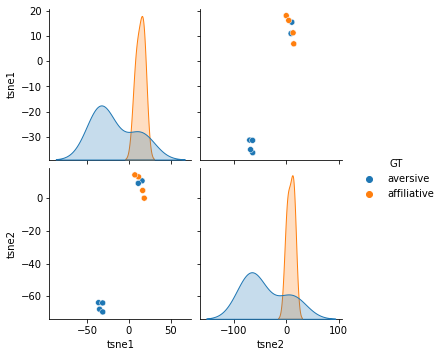

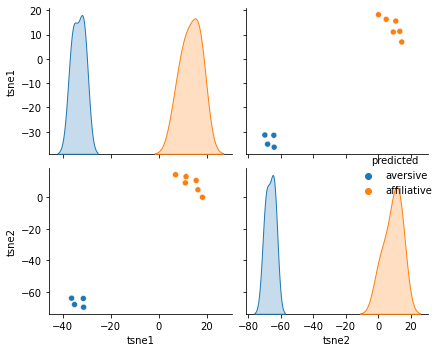

In [92]:
from sklearn.manifold import TSNE
X = X_test_imp
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

df_results_test[['tsne1','tsne2']] = X_embedded

sns.pairplot(df_results_test[['GT','tsne1','tsne2']], hue='GT')

sns.pairplot(df_results_test[['predicted','tsne1','tsne2']], hue='predicted')

# Display the plots
plt.tight_layout()
plt.show()


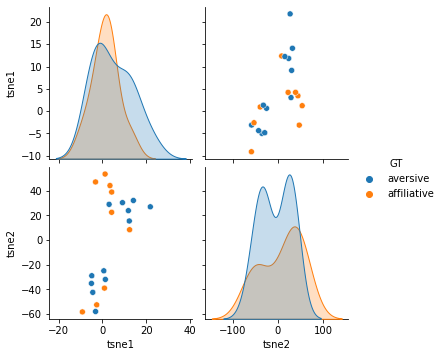

In [96]:
X = X_train_imp
y = y_train
y_pred = y_train_pred
inds = train_inds

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(X)

df_results_test = pd.DataFrame(df_all_data_flag.iloc[inds]['files'])
df_results_test['GT'] = y
df_results_test['predicted'] = y_pred
df_results_test['correct'] = df_results_test['GT'] == df_results_test['predicted']
# df_results_test['confidence'] = confidence_levels

df_results_test[['tsne1','tsne2']] = X_embedded
# df_results_test
sns.pairplot(df_results_test[['GT','tsne1','tsne2']], hue='GT')

# sns.pairplot(df_results_test[['predicted','tsne1','tsne2']], hue='predicted')

# # Display the plots
# plt.tight_layout()
# plt.show()

In [97]:
# All data (train and test)


X = np.append(X_train_imp, X_test_imp, axis=0)
y = np.append(y_train, y_test)
y_pred = np.append(y_train_pred, y_test_pred)

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=10, n_iter=5000).fit_transform(X)


df_res_tsne = pd.DataFrame(y, columns=['GT'])
df_res_tsne['dataset'] = np.append(np.full(y_train.shape, "train"), np.full(y_test.shape, "test"))
df_res_tsne['predicted'] = y_pred
df_res_tsne['correct'] = df_res_tsne['predicted'] == df_res_tsne['GT']
df_res_tsne[['tsne1','tsne2']] = X_embedded
#Seaborn pair plot

# sns.pairplot(df_res_tsne[['GT','tsne1','tsne2']], hue='GT')

# sns.pairplot(df_res_tsne[['predicted','tsne1','tsne2']], hue='predicted')

# # Display the plots
# plt.tight_layout()
# plt.show()

In [98]:
df_res_tsne.head(1)

,GT,dataset,predicted,correct,tsne1,tsne2
0,aversive,train,aversive,True,-0.725429,11.951173


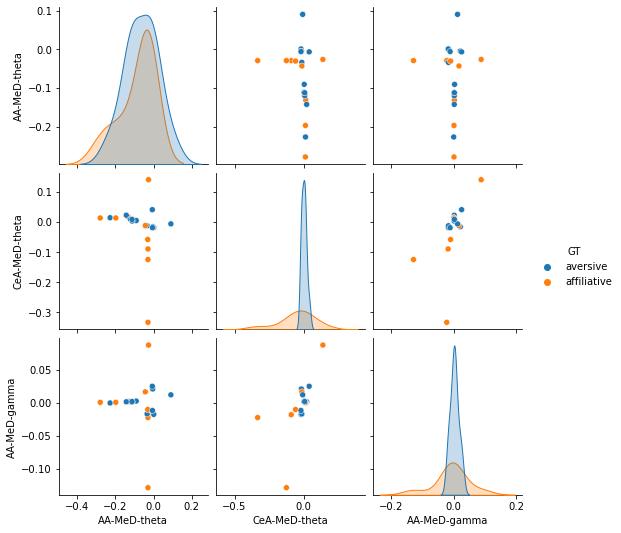

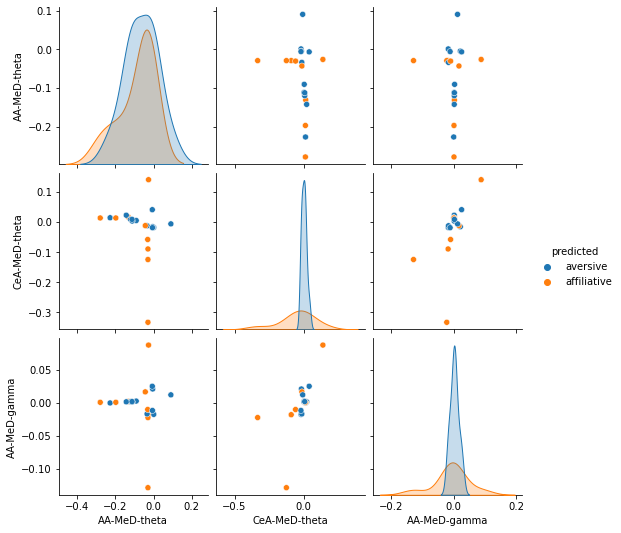

In [104]:
X = X_train_imp
y = y_train
y_pred = y_train_pred

df_X_imp = pd.DataFrame(X)

df_X_imp = df_X_imp.rename(columns={0:'AA-MeD-theta' , 1:'CeA-MeD-theta', 2:'AA-MeD-gamma'})
df_X_imp['GT'] = y
df_X_imp['predicted'] = y_pred
df_X_imp['correct'] = df_X_imp['predicted'] == df_X_imp['GT']

sns.pairplot(data=df_X_imp[['AA-MeD-theta','CeA-MeD-theta','AA-MeD-gamma','GT']], hue='GT')
sns.pairplot(data=df_X_imp[['AA-MeD-theta','CeA-MeD-theta','AA-MeD-gamma','predicted']], hue='predicted')


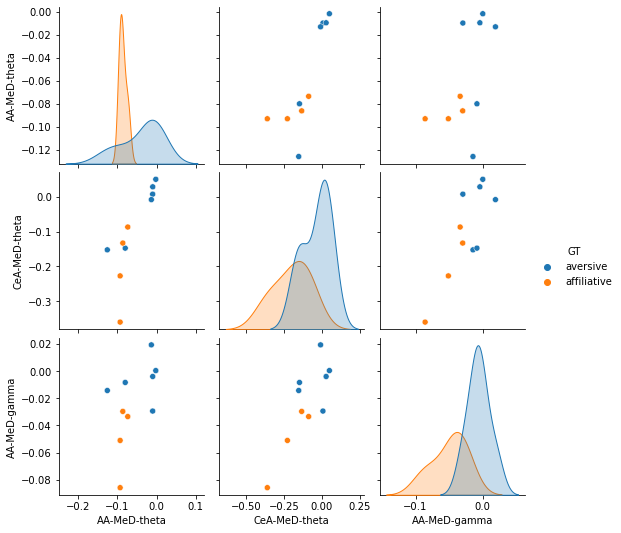

In [105]:
X = X_test_imp
y = y_test
y_pred = y_test_pred

df_X_imp = pd.DataFrame(X)

df_X_imp = df_X_imp.rename(columns={0:'AA-MeD-theta' , 1:'CeA-MeD-theta', 2:'AA-MeD-gamma'})
df_X_imp['GT'] = y
df_X_imp['predicted'] = y_pred
df_X_imp['correct'] = df_X_imp['predicted'] == df_X_imp['GT']

sns.pairplot(data=df_X_imp[['AA-MeD-theta','CeA-MeD-theta','AA-MeD-gamma','GT']], hue='GT')
# sns.pairplot(data=df_X_imp[['AA-MeD-theta','CeA-MeD-theta','AA-MeD-gamma','predicted']], hue='predicted')


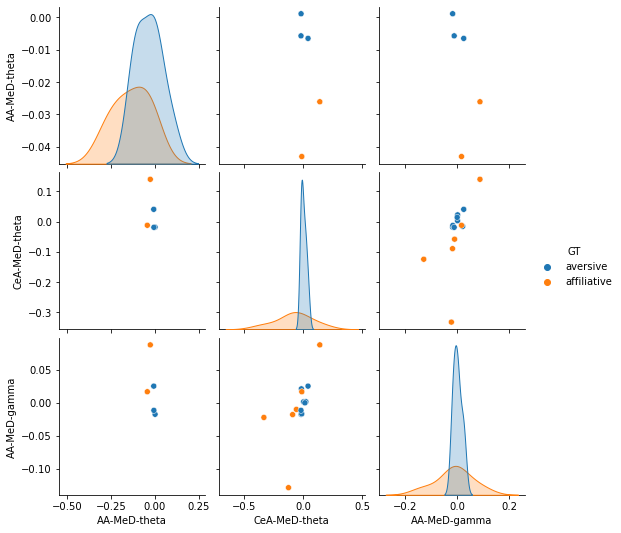

In [106]:
X = X_train
y = y_train
y_pred = y_train_pred

df_X_imp = pd.DataFrame(X)

df_X_imp = df_X_imp.rename(columns={0:'AA-MeD-theta' , 1:'CeA-MeD-theta', 2:'AA-MeD-gamma'})
df_X_imp['GT'] = y
df_X_imp['predicted'] = y_pred
df_X_imp['correct'] = df_X_imp['predicted'] == df_X_imp['GT']

sns.pairplot(data=df_X_imp[['AA-MeD-theta','CeA-MeD-theta','AA-MeD-gamma','GT']], hue='GT', dropna=True)
# sns.pairplot(data=df_X_imp[['AA-MeD-theta','CeA-MeD-theta','AA-MeD-gamma','predicted']], hue='predicted', dropna=True)


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


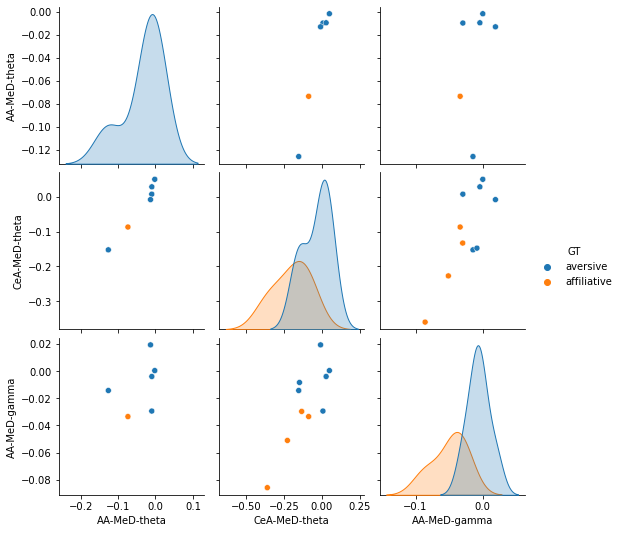

In [103]:
X = X_test
y = y_test
y_pred = y_test_pred

df_X_imp = pd.DataFrame(X)

df_X_imp = df_X_imp.rename(columns={0:'AA-MeD-theta' , 1:'CeA-MeD-theta', 2:'AA-MeD-gamma'})
df_X_imp['GT'] = y
df_X_imp['predicted'] = y_pred
df_X_imp['correct'] = df_X_imp['predicted'] == df_X_imp['GT']

sns.pairplot(data=df_X_imp[['AA-MeD-theta','CeA-MeD-theta','AA-MeD-gamma','GT']], hue='GT', dropna=True)
# sns.pairplot(data=df_X_imp[['AA-MeD-theta','CeA-MeD-theta','AA-MeD-gamma','predicted']], hue='predicted', dropna=True)


### Impute the missing values of all the dataset before training and testing

Performing imputation before splitting the dataset can potentially lead to data leakage and overly optimistic evaluation results. It's generally recommended to split the dataset into training and testing sets before applying any data preprocessing steps, including imputation.

Data leakage can occur when information from the testing set is inadvertently used during the imputation process. This can lead to overfitting and unrealistic evaluation results because the imputation is informed by the target variable in the testing set.

In [1]:
imputer = IterativeImputer(max_iter=100)
# imputer_class = MissForest

# model_class = RandomForestClassifier
# model = LogisticRegression(max_iter=10000)
# model_class = svm.SVC
model_class = tree.DecisionTreeClassifier

NameError: name 'IterativeImputer' is not defined

In [108]:
data = data.drop('0', axis=1)

In [150]:
# Impute data before splitting it into train and test

imputer = imputer_class()
model = model_class()

imputed_data = imputer.fit_transform(data)

# Splitting the imputed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(imputed_data,
                                                    labels,
                                                    test_size=0.3,
                                                    stratify=labels)


# Creating and training the model (using Logistic Regression as an example)


model.fit(X_train, y_train)


# Making predictions on the training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


# Calculating accuracy scores
# train_accuracy = accuracy_score(y_train.values, y_train_pred)
# test_accuracy = accuracy_score(y_test.values, y_test_pred)
ret_test = eval_model(y_test, y_test_pred)
ret_train = eval_model(y_train, y_train_pred)



df_results_test = pd.DataFrame(y_test, columns={'GT'})
df_results_test['predicted'] = y_test_pred
df_results_test['correct'] = df_results_test['GT'] == df_results_test['predicted']
print(df_results_test)


print('Test')
[print(f'{metric}:{values}') for metric, values in ret_test.items()]
print('Train')
[print(f'{metric}:{values}') for metric, values in ret_train.items()]


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 2


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 3


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 4
            GT    predicted  correct
0  affiliative  affiliative     True
1     aversive     aversive     True
2     aversive  affiliative    False
3     aversive     aversive     True
4     aversive     aversive     True
5     aversive     aversive     True
6     aversive     aversive     True
7  affiliative  affiliative     True
8  affiliative  affiliative     True
9  affiliative     aversive    False
Test
accuracy:0.8
precision:0.75
recall:0.75
f1:0.75
Train
accuracy:1.0
precision:1.0
recall:1.0
f1:1.0


[None, None, None, None]

### Imputing the data after each splitting

The imputaion quality drops when performing on smaller sub sets

In [151]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score



# Splitting the imputed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    labels,
                                                    test_size=0.3,
                                                    stratify=labels)

imputer = imputer_class()
model = model_class()

imputed_data_train = imputer.fit_transform(X_train)
imputed_data_test = imputer.fit_transform(X_test)

# Converting the imputed data back to a DataFrame
imputed_data_train = pd.DataFrame(imputed_data_train, columns=X_train.columns)
imputed_data_test = pd.DataFrame(imputed_data_test, columns=X_test.columns)



# Creating and training the model (using Logistic Regression as an example)
# model = LogisticRegression()
model.fit(imputed_data_train, y_train)

# Making predictions on the training and testing sets
y_train_pred = model.predict(imputed_data_train)
y_test_pred = model.predict(imputed_data_test)

# Calculating accuracy scores
# train_accuracy = accuracy_score(y_train.values, y_train_pred)
# test_accuracy = accuracy_score(y_test.values, y_test_pred)
ret_test = eval_model(y_test, y_test_pred)
ret_train = eval_model(y_train, y_train_pred)


df_results_test = pd.DataFrame(y_test, columns={'GT'})
df_results_test['predicted'] = y_test_pred
df_results_test['correct'] = df_results_test['GT'] == df_results_test['predicted']
print(df_results_test)




print('Test')
[print(f'{metric}:{values}') for metric, values in ret_test.items()]
print('Train')
[print(f'{metric}:{values}') for metric, values in ret_train.items()]



C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1
            GT    predicted  correct
0     aversive  affiliative    False
1  affiliative     aversive    False
2     aversive     aversive     True
3     aversive     aversive     True
4  affiliative  affiliative     True
5     aversive  affiliative    False
6     aversive     aversive     True
7  affiliative  affiliative     True
8  affiliative  affiliative     True
9     aversive     aversive     True
Test
accuracy:0.7
precision:0.6
recall:0.75
f1:0.667
Train
accuracy:1.0
precision:1.0
recall:1.0
f1:1.0


[None, None, None, None]

### Cross validation
Since the data plitting have significant effect on the model performance, cross validation is important

In [152]:
def one_fold(X_train, X_test, y_train, y_test):
        # Splitting the imputed data into training and testing sets


    imputer = imputer_class(max_iter=500)
    model = model_class()
    
    imputed_data_train = imputer.fit_transform(X_train)
    imputed_data_test = imputer.fit_transform(X_test)

    # Converting the imputed data back to a DataFrame
#     imputed_data_train = pd.DataFrame(imputed_data_train, columns=X_train.columns)
#     imputed_data_test = pd.DataFrame(imputed_data_test, columns=X_test.columns)
    
    # debug
#     print(imputed_data_test.shape)
#     print(imputed_data_test.shape)


    # Creating and training the model (using Logistic Regression as an example)
    
    model.fit(imputed_data_train, y_train)

    # Making predictions on the training and testing sets
    y_train_pred = model.predict(imputed_data_train)
    y_test_pred = model.predict(imputed_data_test)
    
    return y_train, y_train_pred, y_test, y_test_pred

In [153]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

# Define the cross-validation strategy
cv = KFold(n_splits=3, shuffle=True)
# cv = StratifiedKFold(n_splits=2, shuffle=True)

cv_scores_train = []
cv_scores_test = []

# for train_index, test_index in cv.split(data, rat_numbers):
for train_index, test_index in cv.split(data):
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    y_train, y_train_pred, y_test, y_test_pred = one_fold(X_train, X_test, y_train, y_test)
    scores_train = eval_model(y_train, y_train_pred)
    scores_test = eval_model(y_test, y_test_pred)
    cv_scores_train.append(scores_train)
    cv_scores_test.append(scores_test)
    
# Summarize
ret_train = pd.DataFrame(cv_scores_train).mean()
ret_test = pd.DataFrame(cv_scores_test).mean()






C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 2


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 3


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 4


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 5


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 2


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 3


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 4


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 2


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 3


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 4


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 5
Iteration: 6


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [154]:
print('Test')
print(ret_test)

print('Train')
print(ret_train)

# print('Test')
# [[print(f'{metric}:{values}') for metric, values in ret.items()] for ret in cv_scores_test]
# print('Train')
# [[print(f'{metric}:{values}') for metric, values in ret.items()] for ret in cv_scores_train]


Test
accuracy     0.612000
precision    0.652000
recall       0.583333
f1           0.519333
dtype: float64
Train
accuracy     1.0
precision    1.0
recall       1.0
f1           1.0
dtype: float64


In [155]:
 pd.DataFrame(cv_scores_test)

,accuracy,precision,recall,f1
0,0.636,0.556,1.00,0.714
1,0.500,0.400,0.50,0.444
2,0.700,1.000,0.25,0.400


### Impute the data and see how it looks

In [156]:
imputer = imputer_class(1000)
imputed_data = imputer.fit_transform(data)

C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 0


C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explic

Iteration: 1


In [159]:
labels_num = np.array(labels=='affiliative', dtype=float)*0.1
labels_num = labels_num[:, np.newaxis]

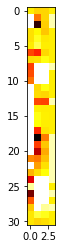

In [160]:

data_conc = np.concatenate((data.values, labels_num), axis=1)
plt.imshow(data_conc, cmap='hot', interpolation='nearest')
plt.show()

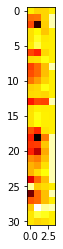

In [161]:
imputed_data_concat = np.concatenate((imputed_data, labels_num), axis=1)
plt.imshow(imputed_data_concat, cmap='hot', interpolation='nearest')
plt.show()


In [162]:
from sklearn.manifold import TSNE
X = imputed_data
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=15).fit_transform(X)
X_embedded.shape

(31, 2)

In [164]:
from sklearn.preprocessing import LabelEncoder

strings = filenames
label_encoder = LabelEncoder()
converted_numbers = label_encoder.fit_transform(strings)

strings = filenames
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(labels)

converted_numbers


rat_numbers = [extract_ratnum_from_file_name(filename) for filename in filenames]


In [165]:
df_tsne = pd.DataFrame(X_embedded)

df_tsne['labels'] = labels
df_tsne['filenames'] = converted_numbers
df_tsne['rat_number'] = rat_numbers
# df_tsne['pred'] = 


In [166]:
# get the dummies and store it in a variable
dummies = pd.get_dummies(df_tsne.labels)
 
# Concatenate the dummies to original dataframe
merged = pd.concat([df_tsne, dummies], axis='columns')
 
# drop the values
merged.drop(['labels'], axis='columns')

merged = merged[['rat_number','affiliative','aversive']].groupby('rat_number').sum()
merged['sum'] = merged['affiliative'] + merged['aversive']
merged

,affiliative,aversive,sum
rat_number,,,
3,2,2,4
4,1,2,3
10,0,4,4
12,0,1,1
15,1,2,3
16,1,2,3
17,0,3,3
19,3,1,4
20,1,0,1


<AxesSubplot:xlabel='0', ylabel='1'>

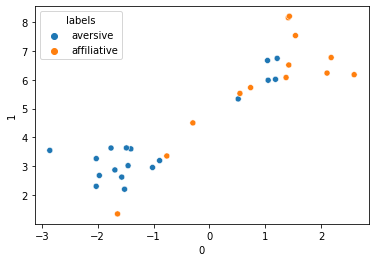

In [167]:
sns.scatterplot(data=df_tsne, x=0, y=1, hue='labels')

In [169]:
# sns.catplot(data=df_tsne, x=0, y=1, hue='rat_number', row='labels')

In [170]:
# sns.catplot(data=df_tsne, x=0, y=1, hue='filenames', row='labels')

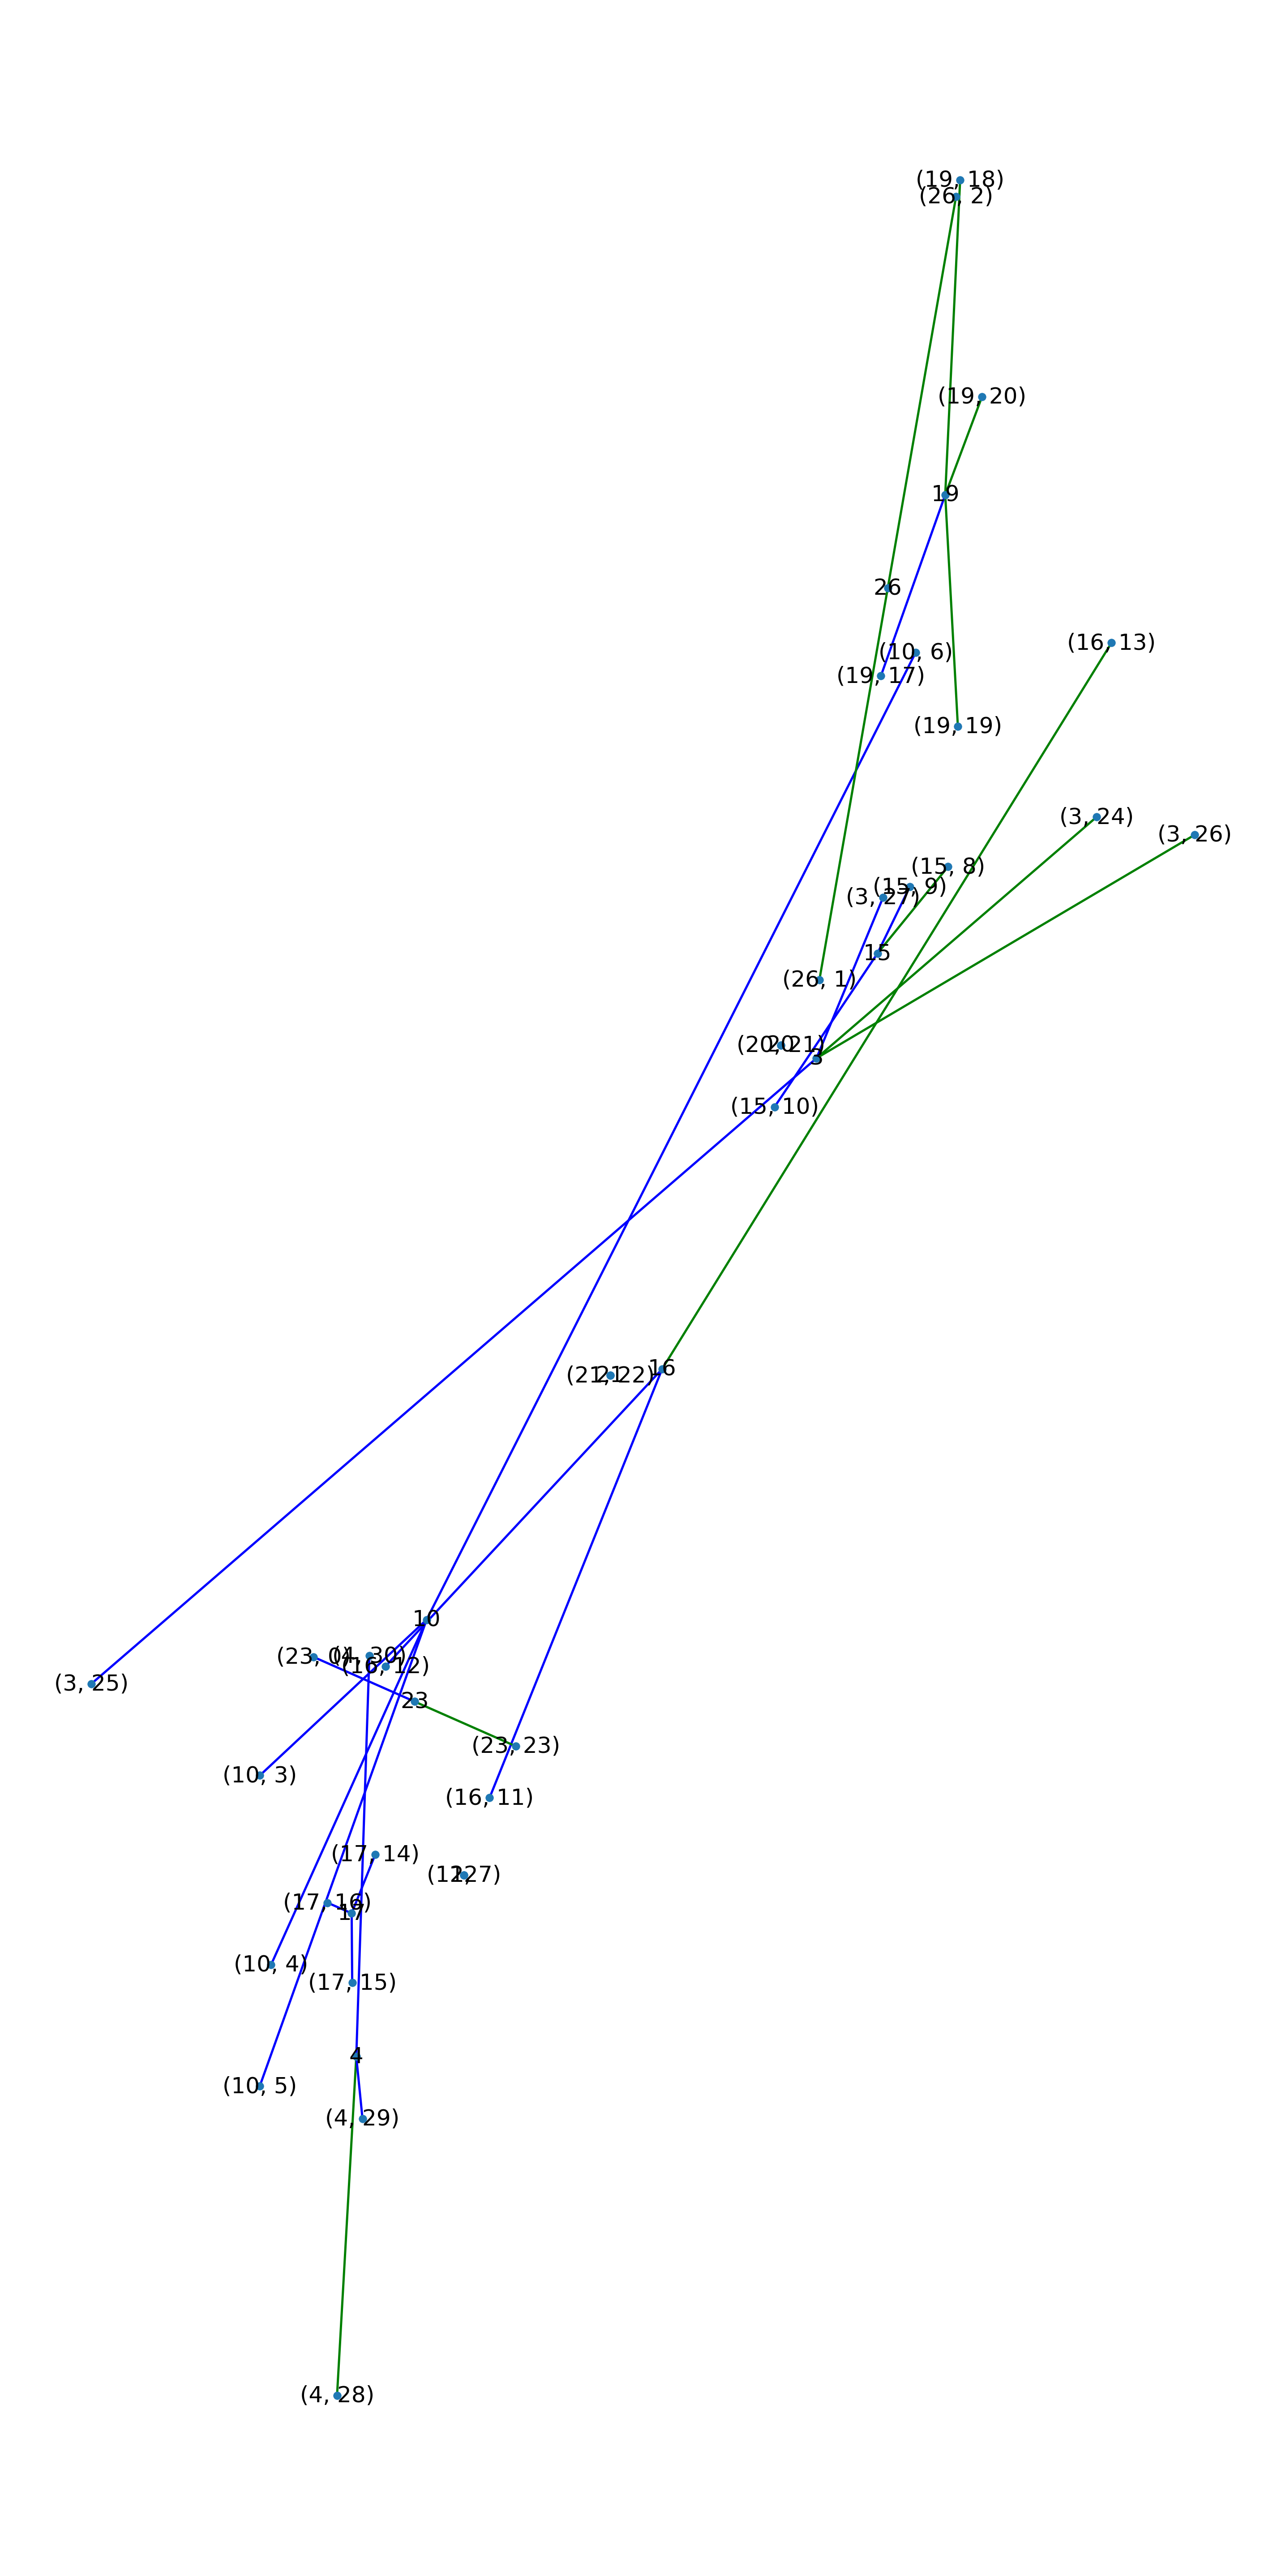

In [172]:
G = nx.Graph()
all_pos = {}
colors = []
for r, df_r in df_tsne.groupby('rat_number'):


    f_names = df_r['filenames'].values
    pos_ = df_r[[0,1]].values
    pos_2 = {(r,f): p for p, f in zip(pos_,f_names)}
    mean_pos = np.mean(pos_,axis=0)
    pos_2[r] = mean_pos
    
    labels_sub = np.array(['b']* len(df_r))
    labels_sub[np.where(np.array(df_r['labels']=='affiliative'))] = 'g'
    
    all_pos.update(pos_2)
    [G.add_edge(r, (r,f)) for f in f_names]
    colors = np.append(colors, labels_sub)
# colors = np.array(colors).flatten()
fig = plt.figure(figsize=(40,80))
# nx.draw_networkx(G,all_pos)
nx.draw_networkx(G,all_pos, edge_color=colors, font_size=50,width=5)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [175]:
# G = nx.Graph()
# all_pos = {}
# df_g = df_tsne.groupby('rat_number')
# n_groups = len(df_g)
# fig = plt.figure(figsize=(40,80))
# for n, (r, df_r) in enumerate(df_g):
#     G = nx.Graph()
#     plt.subplot(n_groups,1,n+1)

#     f_names = df_r['filenames'].values
#     pos_ = df_r[[0,1]].values
#     labels_sub = np.array(['b']* len(df_r))
#     labels_sub[np.where(np.array(df_r['labels']=='affiliative'))] = 'g'
# #     labels_sub = np.append(labels_sub, 'y', axis=None)
    
    
#     pos_2 = {(r,f): p for p, f in zip(pos_,f_names)}
#     mean_pos = np.mean(pos_,axis=0)
    
#     pos_2[r] = mean_pos
    
#     all_pos.update(pos_2)
#     [G.add_edge(r, (r,f)) for f in f_names]
    

#     nx.draw_networkx(G,pos_2, node_size=2000, font_size=50, edge_color=labels_sub)
#     ax = plt.gca()
#     ax.margins(0.08)
# #     plt.axis("off")
#     plt.tight_layout()
# plt.show()